# Example notebook for running PCA at MQT

We also evaluate the ability of other non-linear methods

In [2]:
import glob, sys
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings

from datetime import datetime, timedelta
from scipy.optimize import curve_fit
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 15})

In [3]:
SITE = 'MQT'

pip_path = '../data/PIP/2019_' + SITE + '/netCDF/'
mrr_path = '../data/MRR/'
met_path = '../data/MET/'

NANO_FACTOR = 1000000000
MIN_INTERVALS_5 = 283

In [15]:
# Create script to loop through dir and plot when we have data from all variables

ds_met = xr.open_dataset(met_path + '2013-2020_' + SITE + '.nc')
times = np.asarray((ds_met['UTC Time'].values / NANO_FACTOR), dtype=int)
utc_time = pd.to_datetime(times, unit='s', origin='unix')
utc_time = utc_time.tz_localize('UTC')
est_time = utc_time.tz_convert('US/Eastern')
ds_met = ds_met.assign_coords(time=est_time)
ds_met['time'] = ds_met['time'].astype('datetime64[ns]')

mrr_dates = []
for file in list(glob.glob(mrr_path + '*.nc')):                                       
    mrr_dates.append(file[-16:-8])

print(mrr_dates)
    
pip_dates = []
for file in list(glob.glob(pip_path + '/edensity_distributions/*.nc')):
    pip_dates.append(file[-37:-29])

mrr_ds_dates = []
for date in mrr_dates:
    year = int(date[:4])
    month = int(date[4:6])
    day = int(date[-2:])
    ds = ds_met.sel(time=(ds_met['time'].dt.year==year) & (ds_met['time'].dt.month==month) & (ds_met['time'].dt.day==day))

    if len(ds.time.values) > 0:
        mrr_ds_dates.append(date)
        
met_dates = []
base_date = datetime.strptime('20190101', '%Y%m%d')
for i in range(365):
    new_date = base_date + timedelta(days=i)
    year = new_date.year
    month = new_date.month
    day = new_date.day
    ds = ds_met.sel(time=(ds_met['time.year']==year) & (ds_met['time.month']==month) & (ds_met['time.day']==day))
    
    if len(ds.time.values) > 0:
        met_dates.append(str(year) + str(month) + str(day))

matched_dates = []
for date in mrr_ds_dates:
    files = glob.glob(pip_path + '/*/*' + date + '*.nc')
    if len(files) == 4:
        matched_dates.append(date)
        
print("MRR:", len(mrr_dates), "MET:", len(met_dates), "PIP:", len(pip_dates))
print("Matched:", len(matched_dates))
print(matched_dates)

['20190312', '20190302', '20191125', '20190621', '20190926', '20191231', '20191221', '20190525', '20190208', '20190218', '20190813', '20190803', '20190123', '20190410', '20191010', '20190227', '20190714', '20190909', '20190919', '20191228', '20190722', '20191026', '20190211', '20190201', '20190426', '20190628', '20190115', '20190105', '20190825', '20190503', '20191009', '20190513', '20191019', '20191217', '20191207', '20190910', '20190617', '20190324', '20190419', '20191113', '20190409', '20191103', '20190723', '20191229', '20190210', '20191027', '20190824', '20190427', '20190104', '20190114', '20190629', '20190901', '20190911', '20191018', '20190512', '20191008', '20190502', '20191206', '20191216', '20190616', '20190606', '20191102', '20190408', '20191112', '20190418', '20190325', '20191124', '20190303', '20190313', '20190630', '20190620', '20191220', '20191230', '20190219', '20190209', '20190524', '20190927', '20190122', '20190411', '20190401', '20190802', '20190812', '20190918', '20

KeyboardInterrupt: 

In [4]:
def get_cloud_positions(data):
    cloud_bases = []
    cloud_tops = []

    for col in data.T:  # Transpose to loop over columns
        cloud_base = np.nan
        cloud_top = np.nan
        count = 0
        
        for i in range(len(col)):
            if not np.isnan(col[i]):
                if np.isnan(cloud_base):  # Start of the cloud
                    cloud_base = i
                count += 1
            else:
                if not np.isnan(cloud_base) and count >= 4:  # End of the cloud
                    cloud_top = i - 1  # The last non-NaN value
                    break
                else:  # Reset
                    cloud_base = np.nan
                    count = 0

        if not np.isnan(cloud_base) and (cloud_top is None or np.isnan(cloud_top)):
            # In case the cloud goes up to the last bin in the column
            if count >= 4:
                cloud_top = len(col) - 1
            else:
                # Cloud size is less than 4, reset
                cloud_base = np.nan
                
        cloud_bases.append(cloud_base)
        cloud_tops.append(cloud_top)

    return np.array(cloud_bases)[:283], np.array(cloud_tops)[:283], (np.array(cloud_tops) - np.array(cloud_bases))[:283]

N_0_array = []
lambda_array = []
total_particle_array = []
avg_ed_array = []
avg_sr_array = []
avg_vvd_array = []
mwd_array = []
temp_array = []
rh_array = []
ws_array = []
press_array = []
wd_array = []
base_array = []
top_array = []
depth_array = []

number_of_files = 0
for matched_date in matched_dates:
    print("Working on day", matched_date)
    year = int(matched_date[:4])
    month = int(matched_date[4:6])
    day = int(matched_date[-2:])

    # Load MET data
    ds_met_day = ds_met.sel(time=(ds_met['time.year']==year) & (ds_met['time.month']==month) & (ds_met['time.day']==day))

    # Load MRR data
    ds_mrr_day = xr.open_dataset(mrr_path + 'MRR_NWS_MQT_' + matched_date + '_snow.nc')

    # Load PIP data
    ds_edensity_lwe_rate = xr.open_dataset(pip_path + '/edensity_lwe_rate/006' + matched_date + '2350_01_P_Minute.nc')
    ds_edensity_distributions = xr.open_dataset(pip_path + '/edensity_distributions/006' + matched_date + '2350_01_rho_Plots_D_minute.nc')
    ds_velocity_distributions = xr.open_dataset(pip_path + '/velocity_distributions/006' + matched_date + '2350_01_vvd_A.nc')
    ds_particle_size_distributions = xr.open_dataset(pip_path + '/particle_size_distributions/006' + matched_date + '2350_01_dsd.nc')

    dsd_values = ds_particle_size_distributions['psd'].values
    edd_values = ds_edensity_distributions['rho'].values
    vvd_values = ds_velocity_distributions['vvd'].values
    sr_values = ds_edensity_lwe_rate['nrr'].values
    ed_values = ds_edensity_lwe_rate['ed'].values
    bin_centers = ds_particle_size_distributions['bin_centers'].values

    if len(ds_particle_size_distributions.time) != 1440:
        print("PIP data record too short for day, skipping!")
        continue

    # Print results
    # print("\nMET")
    # print(ds_met_day)

    # print("\nMRR")
    # print(ds_mrr_day)

    # print("\nPIP")
    # print(ds_edensity_lwe_rate)
    # print(ds_edensity_distributions)
    # print(ds_velocity_distributions)
    # print(ds_particle_size_distributions)

    if len(ds_met_day['Temp Out'].values[:MIN_INTERVALS_5]) != 283:
        print("MET data record too short for day, skipping!")
        continue

    ########## MRR CALCULATIONS
    data = ds_mrr_day['Ze'].values.T[:,:1440]
    if data.shape[1] < 1440:
        print("MRR data record too short for day, skipping!")
        continue

    data_reshaped = data.reshape(31, 1440 // 5, 5)
    data = np.nanmean(data_reshaped, axis=-1)
    mask = data < -5
    data[mask] = np.nan
    cloud_bases, cloud_tops, cloud_depths = get_cloud_positions(data)

    # Plot MRR data
    # fig, ax = plt.subplots(figsize=(12,3))
    # plt.imshow(data, cmap = cm.gist_ncar, vmin = -10, vmax = 30, aspect='auto', interpolation='bilinear')
    # plt.axhline(y=2, color='gray', linestyle='--')
    # plt.scatter(np.arange(len(cloud_bases)), cloud_bases, color='blue', marker='x')
    # plt.scatter(np.arange(len(cloud_tops)), cloud_tops, color='red', marker='x')
    # plt.plot(np.arange(len(cloud_depths)), cloud_depths, color='black', linestyle='--')
    # plt.gca().invert_yaxis()
    # plt.show()

    base_array.append(cloud_bases)
    top_array.append(cloud_tops)
    depth_array.append(cloud_depths)

    ########## PIP CALCULATIONS
    func = lambda t, a, b: a * np.exp(-b*t)

    # Loop over each 5-minute block
    count = 0
    for i in range(0, dsd_values.shape[0], 5):
        if i >= 1415:
            continue

        count += 1
        block_avg = np.mean(dsd_values[i:i+5, :], axis=0)
        valid_indices = ~np.isnan(block_avg)
        block_avg = block_avg[valid_indices]
        valid_bin_centers = bin_centers[valid_indices]

        if block_avg.size == 0:
            N_0_array.append(np.nan)
            lambda_array.append(np.nan)
            avg_vvd_array.append(np.nan)
            avg_ed_array.append(np.nan)
            avg_sr_array.append(np.nan)
            total_particle_array.append(0)
            mwd_array.append(np.nan)
            continue

        # Calculate average fallspeed over the 5-minute interval
        avg_vvd_array.append(np.nanmean(vvd_values[i:i+5, :], axis=(0, 1)))

        # Calculate the average eDensity of the 5-minute interval
        avg_ed_array.append(np.nanmean(ed_values[i:i+5]))

        # Calculate the average snowfall rate over the 5-minute interval
        avg_sr_array.append(np.nanmean(sr_values[i:i+5]))

        # Calculate total number of particles over the 5-minute interval
        total_particle_array.append(np.nansum(dsd_values[i:i+5, :], axis=(0, 1)))

        # Calculate mean mass diameter over the 5-minute interval
        mass_dist = edd_values[i:i+5, valid_indices] * dsd_values[i:i+5, valid_indices] * (4/3) * np.pi * (valid_bin_centers/2)**3
        mass_weighted_diameter = np.sum(mass_dist * valid_bin_centers) / np.sum(mass_dist)
        mwd_array.append(mass_weighted_diameter)

        # Calculate N0 and Lambda
        try:
            popt, pcov = curve_fit(func, valid_bin_centers, block_avg, p0 = [1e4, 2], maxfev=600)
            if popt[0] > 0 and popt[0] < 10**7 and popt[1] > 0 and popt[1] < 10:
                N_0_array.append(popt[0])
                lambda_array.append(popt[1])
            else:
                N_0_array.append(np.nan)
                lambda_array.append(np.nan)

        except RuntimeError:
            N_0_array.append(np.nan)
            lambda_array.append(np.nan)


    ########## MET CALCULATIONS
    temp_array.append(ds_met_day['Temp Out'].values[:MIN_INTERVALS_5])
    rh_array.append(ds_met_day['RH Out'].values[:MIN_INTERVALS_5])
    ws_array.append(ds_met_day['Wind Speed'].values[:MIN_INTERVALS_5])
    press_array.append(ds_met_day['Pressure'].values[:MIN_INTERVALS_5])
    wd_array.append(ds_met_day['Wind Dir'].values[:MIN_INTERVALS_5])
    number_of_files += 1

top_array = [item for sublist in top_array for item in sublist]
base_array = [item for sublist in base_array for item in sublist]
depth_array = [item for sublist in depth_array for item in sublist]
temp_array = [item for sublist in temp_array for item in sublist]
rh_array = [item for sublist in rh_array for item in sublist]
ws_array = [item for sublist in ws_array for item in sublist]
press_array = [item for sublist in press_array for item in sublist]
wd_array = [item for sublist in wd_array for item in sublist]


df = pd.DataFrame(data={'n0': N_0_array,  'D0': mwd_array, 'Nt': total_particle_array, \
                        'Fs': avg_vvd_array, 'Sr': avg_sr_array,  'Ed': avg_ed_array, \
                        'lambda': lambda_array, 'Ct': top_array, 'Cb': base_array, \
                        'Cd': depth_array, 't': temp_array, 'q': rh_array, 'Ws': ws_array, \
                        'u': press_array, 'Wd': wd_array})
df.to_csv('../data/processed/psd_inputs/MQT_2019.csv')

    # break

print("all done")



Working on day 20191125
Working on day 20190621
Working on day 20190926
Working on day 20190525
MRR data record too short for day, skipping!
Working on day 20190813
Working on day 20190803
Working on day 20190123
Working on day 20190410
Working on day 20191010
Working on day 20190714
MRR data record too short for day, skipping!
Working on day 20190909
Working on day 20190919
Working on day 20191228
Working on day 20190722
Working on day 20190201
MET data record too short for day, skipping!
Working on day 20190426
Working on day 20190628
Working on day 20190115
Working on day 20190105
Working on day 20190825
Working on day 20190503
Working on day 20191009
Working on day 20190513
Working on day 20191019
Working on day 20191217
Working on day 20191207
Working on day 20190910
Working on day 20190617
Working on day 20191113
Working on day 20190409
Working on day 20191103
Working on day 20190723
Working on day 20191229
MRR data record too short for day, skipping!
Working on day 20190114
Work

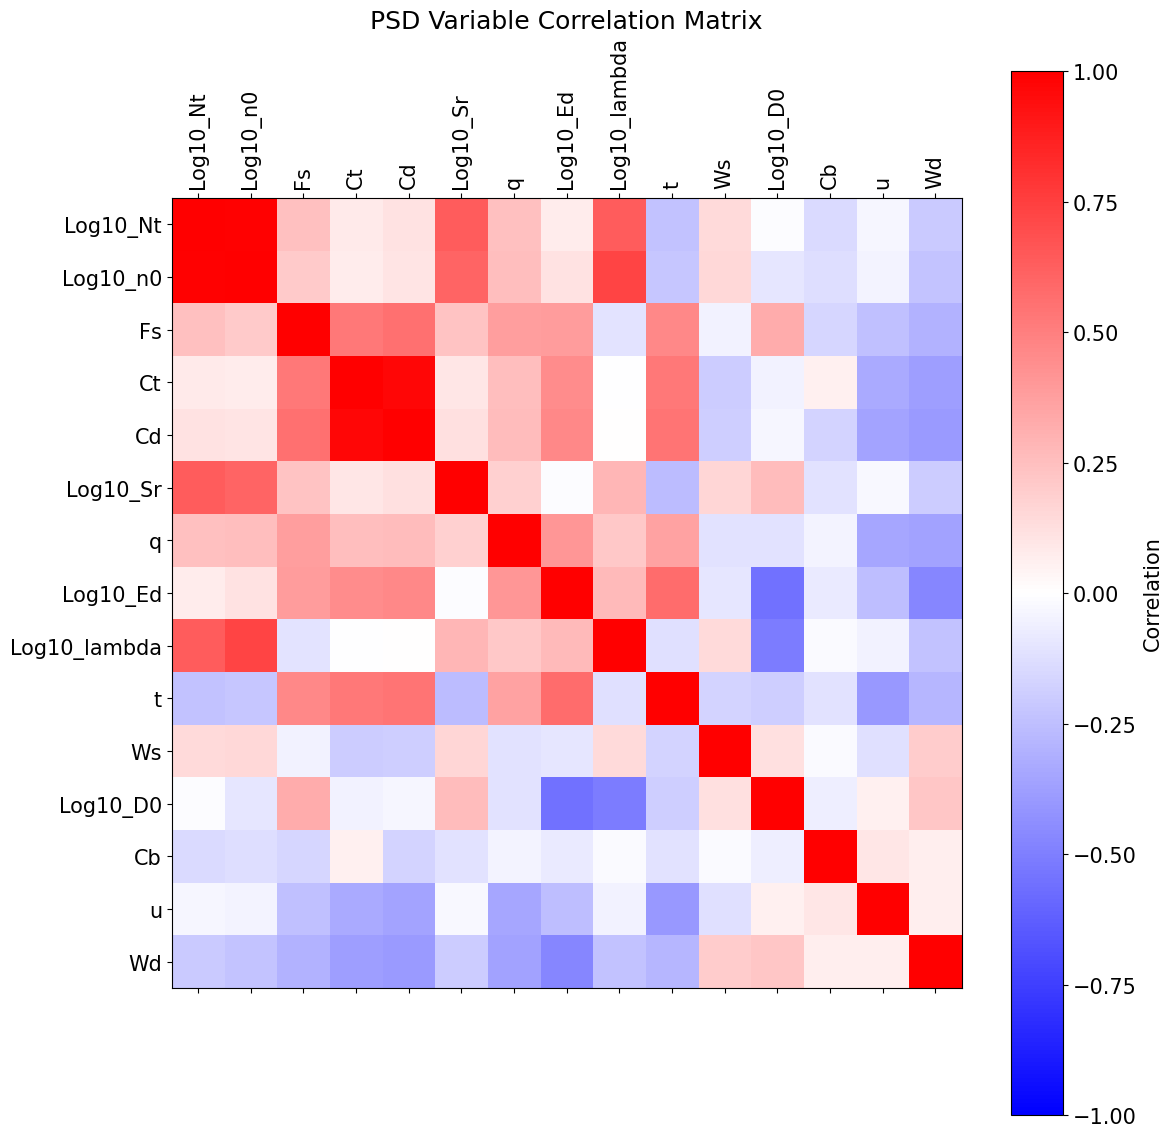

             Fs    Ct   Cb    Cd         t     q       Ws            u     Wd  \
120    0.114934  29.0  2.0  27.0 -0.333333  94.0  0.44704   998.950643  202.5   
121    0.112550  29.0  2.0  27.0 -0.222222  93.0  0.89408   998.849051  202.5   
123    0.094134  23.0  2.0  21.0 -0.055556  94.0  0.89408   998.815187  180.0   
124    0.073379  29.0  2.0  27.0  0.055556  94.0  0.89408   998.747459  180.0   
125    0.077369  29.0  2.0  27.0  0.166667  93.0  0.89408   998.679732  157.5   
...         ...   ...  ...   ...       ...   ...      ...          ...    ...   
68312  0.073898  16.0  2.0  14.0  2.833333  98.0  3.57632  1011.581870    0.0   
68313  0.035696  15.0  2.0  13.0  2.888889  98.0  4.02336  1011.615734    0.0   
68315  0.143669  16.0  2.0  14.0  2.888889  98.0  5.36448  1011.717326    0.0   
68316  0.140304  16.0  2.0  14.0  2.944444  98.0  5.36448  1011.920509    0.0   
68317  0.140676  16.0  2.0  14.0  2.944444  98.0  4.91744  1011.920509    0.0   

       Log10_n0  Log10_lamb

In [5]:


def plot_corr(df, size=12):
    # Calculate correlations
    corr = df.corr()
    
    # Calculate the correlation sum
    corr_sum = corr.sum().sort_values(ascending=False)
    
    # Reorder the dataframe according to the correlation sum
    corr = corr.loc[corr_sum.index, corr_sum.index]

    # Create a DataFrame correlation plot
    fig, ax = plt.subplots(figsize=(size, size))
    plt.title("PSD Variable Correlation Matrix")
    h = ax.matshow(corr, cmap='bwr', vmin=-1, vmax=1)
    fig.colorbar(h, ax=ax, label='Correlation')  # Use fig.colorbar() to make the colorbar the same height as the plot
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.tight_layout()
    plt.show()

df = pd.read_csv('../data/processed/psd_inputs/MQT_2019.csv')
df = df.dropna()
df = df[(df['Ed'] >= 0) & (df['Ed'] <= 4)]
df = df[(df['Wd'] >= 0)]
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['Log10_n0'] = df['n0'].apply(np.log)
df['Log10_lambda'] = df['lambda'].apply(np.log)
df['Log10_Ed'] = df['Ed'].apply(np.log)
df['Log10_D0'] = df['D0'].apply(np.log)
df['Log10_Sr'] = df['Sr'].apply(np.log)
df['Log10_Nt'] = df['Nt'].apply(np.log)
df.drop(columns=['Nt', 'n0', 'lambda', 'Ed', 'D0', 'Sr'], inplace=True)
plot_corr(df)

print(df)


In [7]:
sns_plot = sns.pairplot(df, kind="hist", height=5)
# sns_plot.map_lower(sns.kdeplot, levels=5, color=".2")
sns_plot.savefig('output_kde.png')